In [1]:
import numpy as np
import pandas as pd

train_path = "X_train.csv"
label_path = "y_train.csv"
test_path = "X_test.csv"
samples_path = "samples.csv"

df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
labeldf = pd.read_csv(label_path)


labels = labeldf.values
data = df.values
test_data = test_df.values

data = data[:,1:]
test_data = test_data[:,1:]
labels = labels[:,1]


print(data.shape)
print(test_data.shape)
print(labels.shape)



(5117, 17813)
(3411, 17813)
(5117,)


In [2]:
def count_instances(labels):
    unique, counts = np.unique(labels,return_counts=True)
    return dict(zip(unique,counts))

class_counts = count_instances(labels)

print("Class 0 Counts: {}".format(class_counts[0]))
print("Class 1 Counts: {}".format(class_counts[1]))
print("Class 2 Counts: {}".format(class_counts[2]))
print("Class 3 Counts: {}".format(class_counts[3]))


(num_train, max_timesteps) = data.shape
(num_test, _) = test_data.shape

Class 0 Counts: 3030
Class 1 Counts: 443
Class 2 Counts: 1474
Class 3 Counts: 170


In [3]:
# dk why I did this, might end up useful
def min_len(data):
    # faster to search column wise
    wherenan = np.isnan(data)
    for j in range(data.shape[1]):
        if np.any(wherenan[:,j]):
            return j
    """
    min_len = data.shape[1]
    for i in range(data.shape[0]):
        cond = np.isnan(data[i,:])
        if np.any(cond):
            nan_index = np.where(cond)[0][0]
            if nan_index < min_len:
                min_len = nan_index
            
    return min_len
    """
    
def fill_periodic(data):
    nanplaces = np.isnan(data)
    num_col = data.shape[1]
    for i in range(data.shape[0]):
        stop_index = np.argmax(nanplaces[i,:]==True)-1
        data[i,:] = np.resize(data[i,:stop_index],num_col)
    return data

def fill_zero(data):
    return np.nan_to_num(data)

def fft_zero_pad(data):
    zero_padded = np.nan_to_num(data)
    return np.fft.fft(zero_padded, axis=0)

# implementing below link
# https://dsp.stackexchange.com/questions/25435/dft-for-audio-classification-signals-of-different-lengths
def fft_mod_min(data):
    l = min_len(data)
    # a divisor of the column number
    split_size = data.shape[1]/379
    zero_padded = np.nan_to_num(data)
    splits = np.split(zero_padded,split_size, axis = 1)
    splits = np.array(splits)
    # caution: not sure if the order of rows gets messed up here
    # so that the labels correspond to the correct order
    splits = splits.transpose(1,0,2)
    sums = np.sum(splits, axis = 1)
    
    return np.fft.fft(sums,axis=0)

#mod_min_fft_train = fft_mod_min(data)
#zero_pad_fft_train = fft_zero_pad(data)

#mod_min_fft_test = fft_mod_min(test_data)
#zero_pad_fft_test = fft_zero_pad(test_data)

#print("Mod_min FFt shape {}".format(mod_min_fft_train.shape))
#print("Zero Padded FFt shape {}".format(zero_pad_fft_train.shape))

In [4]:
from scipy.signal import spectrogram

def make_spectrogram(data, nperseg=64, noverlap=32):
    padded = np.nan_to_num(data)
    f, t, sxx = spectrogram(x=padded, fs=300,nperseg=nperseg, noverlap=noverlap, axis=1)
    sxx = abs(sxx)
    mask = sxx>0
    sxx[mask] = np.log(sxx[mask])
    return f, t, sxx

f_train, t_train, sxx = make_spectrogram(data)
f_test, t_test, x_test = make_spectrogram(test_data)

#f, t, sxx = spectrogram(x_train,fs=300,axis=1)
#sxx = np.log(sxx)
print(sxx.shape)
print(x_test.shape)


(5117, 33, 555)
(3411, 33, 555)


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: This function is deprecated. Please call randint(0, 5117 + 1) instead


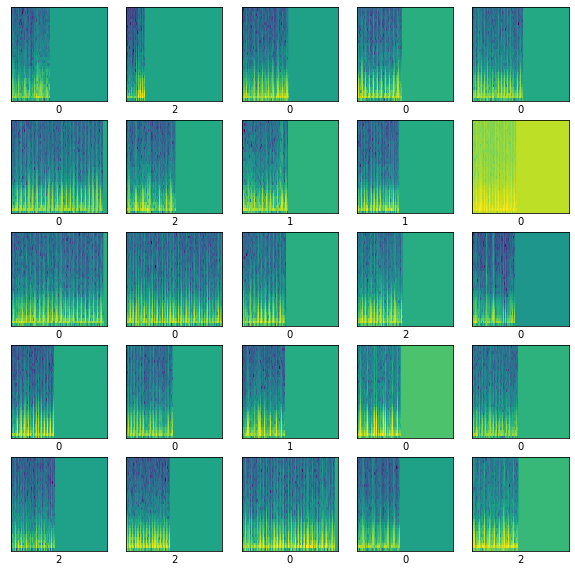

In [11]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

#(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

#train_images = train_images / 255.0


inds = np.random.random_integers(0,5117,25)
plt.figure(figsize=(10,10))
for ii, i in enumerate(inds):
    plt.subplot(5,5,ii+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.pcolormesh(t_train, f_train, sxx[i])
    plt.xlabel(labels[i])

plt.show()

In [12]:
import math



def make_folds(num_folds, data, labels):
    y_0 = np.argwhere(labels==0)
    y_1 = np.argwhere(labels==1)
    y_2 = np.argwhere(labels==2)
    y_3 = np.argwhere(labels==3)

    X_0 = data[y_0].reshape(y_0.shape[0],data.shape[1],data.shape[2])
    X_1 = data[y_1].reshape(y_1.shape[0],data.shape[1],data.shape[2])
    X_2 = data[y_2].reshape(y_2.shape[0],data.shape[1],data.shape[2])
    X_3 = data[y_3].reshape(y_3.shape[0],data.shape[1],data.shape[2])



    num_0 = math.floor(X_0.shape[0]/num_folds)
    num_1 = math.floor(X_1.shape[0]/num_folds)
    num_2 = math.floor(X_2.shape[0]/num_folds)
    num_3 = math.floor(X_3.shape[0]/num_folds)



    y_folds = []
    x_folds = []

    for i in range(num_folds):
    
        y0 = np.zeros((num_0,1))
        y1 = np.ones((num_1,1))
        y2 = np.full((num_2,1),2)
        y3 = np.full((num_3,1),3)
        y = np.concatenate((y0,y1,y2,y3))
        y = y.reshape(y.shape[0],1)
        y_folds.append(y)
        x0 = X_0[i*num_0:(i+1)*num_0,:,:]
        x1 = X_1[i*num_1:(i+1)*num_1,:,:]
        x2 = X_2[i*num_2:(i+1)*num_2,:,:]
        x3 = X_3[i*num_3:(i+1)*num_3,:,:]
        x = np.concatenate((x0,x1,x2,x3))
        x_folds.append(x)
        
    return x_folds, y_folds
    

def balanced_train_val(data, labels, test_prct=0.2):
    
    num_test = math.floor(data.shape[0]*test_prct)
    num_train = data.shape[0]-num_test
    
    x_test = np.zeros((num_test,data.shape[1],data.shape[2]))
    y_test = np.zeros((num_test,1))
    x_train = np.zeros((num_train,data.shape[1],data.shape[2]))
    y_train = np.zeros((num_train,1))
    xs, ys = make_folds(math.ceil(1/test_prct),data,labels)
    print(xs[1].shape)
    for i in range(len(xs)-1):
        x_train = np.concatenate((x_train,xs[i]),axis=0)
        y_train = np.concatenate((y_train,ys[i]),axis=0)
    x_test = xs[len(xs)-1]
    y_test = ys[len(ys)-1]
    
    return x_train, x_test, y_train, y_test
    
    
print(sxx.shape)
img_x = sxx.shape[1]
img_y = sxx.shape[2]

x_train, x_val, y_train, y_val = balanced_train_val(sxx,labels)
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)


class_counts = count_instances(y_train)
print("Class 0 Counts: {}".format(class_counts[0]))
print("Class 1 Counts: {}".format(class_counts[1]))
print("Class 2 Counts: {}".format(class_counts[2]))
print("Class 3 Counts: {}".format(class_counts[3]))

class_countst = count_instances(y_val)
print("Class 0 Counts: {}".format(class_countst[0]))
print("Class 1 Counts: {}".format(class_countst[1]))
print("Class 2 Counts: {}".format(class_countst[2]))
print("Class 3 Counts: {}".format(class_countst[3]))


(5117, 33, 555)
(1022, 33, 555)
(8182, 33, 555)
(1022, 33, 555)
(8182, 1)
(1022, 1)
Class 0 Counts: 6518
Class 1 Counts: 352
Class 2 Counts: 1176
Class 3 Counts: 136
Class 0 Counts: 606
Class 1 Counts: 88
Class 2 Counts: 294
Class 3 Counts: 34


In [13]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]


AttributeError: module 'tensorflow._api.v1.keras.metrics' has no attribute 'AUC'

'1.13.1'

In [22]:
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation="relu", input_shape=(img_x,img_y,1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation="relu"))

model.add(layers.Flatten())
model.add(layers.Dense(64,activation="relu"))
model.add(layers.Dense(10,activation="softmax"))

model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=METRICS)


AttributeError: 'TruePositives' object has no attribute '__name__'

In [71]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)
x_val = x_val.reshape(x_val.shape[0],x_val.shape[1],x_val.shape[2],1)


history = model.fit(x_train, y_train, epochs=10,
                    validation_data=(x_val, y_val))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
#print(test_acc)

Train on 8182 samples, validate on 1022 samples
Epoch 1/3
8182/8182 [==============================] - 46s 6ms/sample - loss: 0.5465 - acc: 0.7980 - val_loss: 0.9829 - val_acc: 0.5920
Epoch 2/3
8182/8182 [==============================] - 47s 6ms/sample - loss: 0.4320 - acc: 0.8285 - val_loss: 0.8988 - val_acc: 0.6272
Epoch 3/3
8182/8182 [==============================] - 50s 6ms/sample - loss: 0.4066 - acc: 0.8343 - val_loss: 0.8119 - val_acc: 0.6507


KeyError: 'accuracy'

In [4]:
from biosppy.signals.ecg import ecg


def extract_heart(data):
    All_ts = []
    All_filtered = []
    All_rpeaks = []
    All_templates_ts = []
    All_templates = []
    All_heart_rate_ts = []
    All_heart_rate = []
    thrown_away = []
    nanplaces = np.isnan(data)
    for i in range(data.shape[0]):
        stop_index = np.argmax(nanplaces[i,:]==True) -1
        try:
            ts, filtered, rpeaks, templates_ts,templates, heart_rate_ts, heart_rate = ecg(data[i,:stop_index], sampling_rate=300,show= False)
        except:
            print("Index {} was bad".format(i))
            thrown_away.append(i)
        """
        print(ts.shape)
        print(filtered.shape)
        print(rpeaks.shape)
        print(templates_ts.shape)
        print(templates.shape)
        print(heart_rate_ts.shape)
        print(heart_rate.shape)
        """
        All_ts.append(ts)
        All_filtered.append(filtered)
        All_rpeaks.append(rpeaks)
        All_templates_ts.append(templates_ts)
        All_templates.append(templates)
        All_heart_rate_ts.append(heart_rate_ts)
        All_heart_rate.append(heart_rate)
        
    return All_ts, All_filtered, All_rpeaks, All_templates_ts, All_templates, All_heart_rate_ts, All_heart_rate, thrown_away
        

ts, filtered, rpeaks, templates_ts,templates, heart_rate_ts, heart_rate, thrown_away= extract_heart(data)


[30]


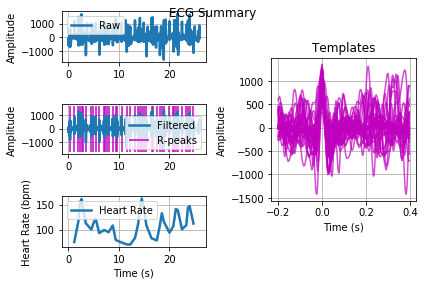

In [28]:
def make_numpy(heart_thing):
    
    heart_np = np.zeros((len(heart_thing),max_timesteps))
    for i in range(heart_np.shape[0]):
        nans = np.empty((1,max_timesteps-len(heart_thing[i])))
        nans[:] = np.nan
        vals = np.array(heart_thing[i]).reshape(1,len(heart_thing[i]))
        heart_np[i,:] = vals#np.concatenate((vals,nans),axis=1)
    return heart_np
"""
ts = make_numpy(ts)
filtered = make_numpy(filtered)
rpeaks = make_numpy(rpeaks)
templates_ts = make_numpy(templates_ts)
templates = make_numpy(templates)
heart_rate_ts = make_numpy(heart_rate_ts)
heart_rate = make_numpy(heart_rate)
"""



In [7]:
x_modtrain, y_modtrain = make_folds(5,mod_min_fft_train,labels)

x_zerotrain, y_zerotrain = make_folds(5,zero_pad_fft_train,labels)




In [31]:
from biosppy.signals.ecg import extract_heartbeats


def extract_heartbeats(data):
    All_rpeaks = []
    All_templates = []
    thrown_away = []
    nanplaces = np.isnan(data)
    for i in range(data.shape[0]):
        stop_index = np.argmax(nanplaces[i,:]==True) -1
        if stop_index > 0:
            templates, rpeaks = extract_heartbeats(signal=data[i,:stop_index],sampling_rate=300)
            All_rpeaks.append(rpeaks)
            All_templates.append(templates)
        else:
            thrown_away.append(i)
        
        
    return All_rpeaks, All_templates, thrown_away

rpeaks, templates, thrown_away = extract_heartbeats(data)

TypeError: extract_heartbeats() got an unexpected keyword argument 'signal'

[30]
[4]
[3]
[0]


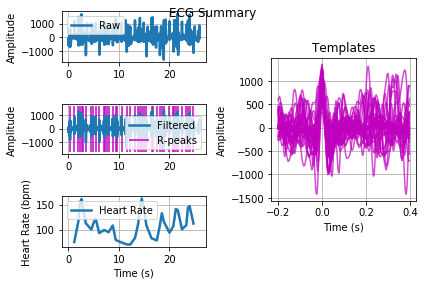

In [31]:
#ts, filtered, rpeaks, templates_ts,templates, heart_rate_ts, heart_rate

from biosppy.plotting import plot_ecg


nanplaces = np.isnan(data)
y_0 = np.argwhere(labels==0)
y_1 = np.argwhere(labels==1)
y_2 = np.argwhere(labels==2)
y_3 = np.argwhere(labels==3)


ind3 = y_3[0]
ind2 = y_2[0]
ind1 = y_1[0]
ind = y_0[0]
print(ind3)
print(ind2)
print(ind1)
print(ind)
stop_index = np.argmax(nanplaces[30,:]==True) -1


ts3, filtered3, rpeaks3, templates_ts3,templates3, heart_rate_ts3, heart_rate3 = ecg(data[30,:stop_index], sampling_rate=300,show= True)




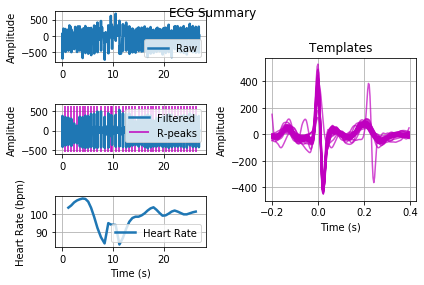

In [32]:
stop_index = np.argmax(nanplaces[4,:]==True) -1


ts2, filtered2, rpeaks2, templates_ts2,templates2, heart_rate_ts2, heart_rate2 = ecg(data[4,:stop_index], sampling_rate=300,show= True)



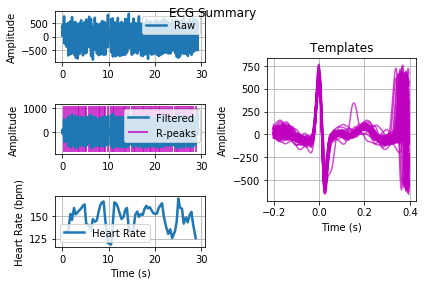

(8768,)
(8768,)
(70,)
(180,)
(70, 180)
(69,)
(69,)


In [41]:
stop_index = np.argmax(nanplaces[3:]==True) -1


ts1, filtered1, rpeaks1, templates_ts1,templates1, heart_rate_ts1, heart_rate1 = ecg(data[3,:stop_index], sampling_rate=300,show= True)

print(ts1.shape)
print(filtered1.shape)
print(rpeaks1.shape)
print(templates_ts1.shape)
print(templates1.shape)
print(heart_rate_ts1.shape)
print(heart_rate1.shape)



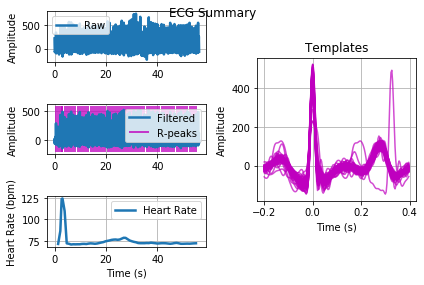

(16855,)
(16855,)
[  167   418   673   827   925  1175  1421  1675  1930  2185  2436  2692
  2946  3197  3449  3702  3955  4202  4452  4707  4957  5204  5453  5697
  5939  6179  6418  6655  6889  7125  7361  7598  7831  8058  8286  8520
  8761  9003  9245  9493  9740  9991 10241 10488 10739 10987 11235 11481
 11732 11983 12233 12482 12731 12981 13231 13483 13736 13983 14230 14480
 14732 14985 15235 15486 15738 15989 16238 16488]
(180,)
(68, 180)
(67,)
(67,)


In [40]:
stop_index = np.argmax(nanplaces[0,:]==True) -1


ts0, filtered0, rpeaks0, templates_ts0,templates0, heart_rate_ts0, heart_rate0 = ecg(data[0,:stop_index], sampling_rate=300,show= True)

print(ts0.shape)
print(filtered0.shape)
print(rpeaks0)
print(templates_ts0.shape)
print(templates0.shape)
print(heart_rate_ts0.shape)
print(heart_rate0.shape)


In [35]:
import math
def min_len(data):
    # faster to search column wise
    wherenan = np.isnan(data)
    for j in range(data.shape[1]):
        if np.any(wherenan[:,j]):
            return j
        
min_len(data)
def pad_periodic(data):
    nanplaces = np.isnan(data)
    for i in range(data.shape[0]):
        stop_index = np.argmax(nanplaces[i,:]==True) -1
        if stop_index > 0:
            rpts = math.floor(data.shape[0]/stop_index)
            print(rpts)
            data[i,:] = np.tile(data[i,:],rpts)
            #print(fill.shape)
        
        
pad_periodic(data)

0


ValueError: could not broadcast input array from shape (0) into shape (17813)

In [20]:
#ts, filtered, rpeaks, templates_ts,templates, heart_rate_ts, heart_rate
#what to fucking do with this shit????


In [58]:
import math


x_folds, y_folds = make_folds(5, sxx, labels)
for i, y in enumerate(y_folds):
    print(y_folds[i].shape)
    print("Number of instances in fold {}".format(i))
    class_counts = count_instances(y_folds[i])
    print("Class 0 Counts: {}".format(class_counts[0]))
    print("Class 1 Counts: {}".format(class_counts[1]))
    print("Class 2 Counts: {}".format(class_counts[2]))
    print("Class 3 Counts: {}".format(class_counts[3]))





(1022, 1)
Number of instances in fold 0
Class 0 Counts: 606
Class 1 Counts: 88
Class 2 Counts: 294
Class 3 Counts: 34
(1022, 1)
Number of instances in fold 1
Class 0 Counts: 606
Class 1 Counts: 88
Class 2 Counts: 294
Class 3 Counts: 34
(1022, 1)
Number of instances in fold 2
Class 0 Counts: 606
Class 1 Counts: 88
Class 2 Counts: 294
Class 3 Counts: 34
(1022, 1)
Number of instances in fold 3
Class 0 Counts: 606
Class 1 Counts: 88
Class 2 Counts: 294
Class 3 Counts: 34
(1022, 1)
Number of instances in fold 4
Class 0 Counts: 606
Class 1 Counts: 88
Class 2 Counts: 294
Class 3 Counts: 34


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 5117 + 1) instead
  del sys.path[0]


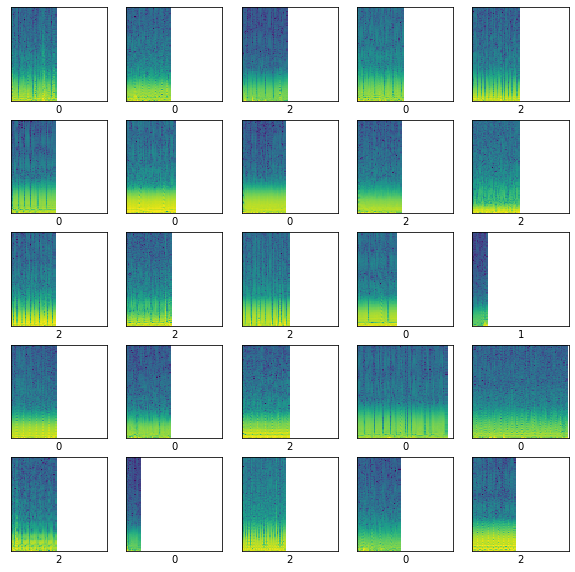

In [61]:

# (image_height,image_width,color_channels)



(129, 79)

[[2.33979118e+01 7.54033902e+01 1.24248665e+03 ...            nan
             nan            nan]
 [6.41374158e+02 1.40320109e+04 8.27686302e+03 ...            nan
             nan            nan]
 [1.77673014e+02 3.95470128e+04 6.98165472e+02 ...            nan
             nan            nan]
 ...
 [4.12687392e-03 9.27713124e-04 2.95274316e-03 ...            nan
             nan            nan]
 [8.46851313e-04 3.81957212e-03 5.29679135e-04 ...            nan
             nan            nan]
 [8.70706655e-03 4.15338926e-03 3.04261599e-05 ...            nan
             nan            nan]]
